### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [406]:
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.


In [407]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]

In [408]:
appendage = "aapl15" # "_15_original" # "_morgan15"
iteration = 3

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
main_file_path = f"main_{appendage}_{iteration}.ipynb"

rerun_opt, rerun_llm, rerun_coord = True, True, True

#### Functions to save data locally

In [409]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                print(f'patched: month {months[i]}\t{ticker}')
            else:
                print(f'skipping: {ticker}')
            
            save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [410]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [411]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [412]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT


100%|██████████| 15/15 [00:00<00:00, 133.83it/s]


Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD


100%|██████████| 15/15 [00:00<00:00, 140.99it/s]


Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL


100%|██████████| 15/15 [00:00<00:00, 162.21it/s]

Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json



  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD


 93%|█████████▎| 14/15 [00:00<00:00, 135.04it/s]

Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD


100%|██████████| 15/15 [00:00<00:00, 135.65it/s]


Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL


100%|██████████| 15/15 [00:00<00:00, 179.26it/s]


Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM


100%|██████████| 15/15 [00:00<00:00, 207.55it/s]


Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE


100%|██████████| 15/15 [00:00<00:00, 132.93it/s]


Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD


100%|██████████| 15/15 [00:00<00:00, 192.66it/s]


Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE


100%|██████████| 15/15 [00:00<00:00, 221.57it/s]


Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD


100%|██████████| 15/15 [00:00<00:00, 207.82it/s]


Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE


100%|██████████| 15/15 [00:00<00:00, 212.67it/s]


Data saved to assets/stock_data.json
skipping: V
Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json


  0%|          | 0/15 [00:00<?, ?it/s]

skipping: AAPL
Data saved to assets/stock_data.json
skipping: MSFT
Data saved to assets/stock_data.json
skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOGL
Data saved to assets/stock_data.json
skipping: META
Data saved to assets/stock_data.json
skipping: JPM
Data saved to assets/stock_data.json
skipping: XOM
Data saved to assets/stock_data.json
skipping: UNH
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json
skipping: HD
Data saved to assets/stock_data.json
skipping: CAT
Data saved to assets/stock_data.json
skipping: PLD
Data saved to assets/stock_data.json
skipping: NEE
Data saved to assets/stock_data.json
skipping: V


100%|██████████| 15/15 [00:00<00:00, 234.06it/s]

Data saved to assets/stock_data.json
skipping: AMD
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Initial stock introductions

In [413]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [414]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        prices = get_stock_price(tickers, datetime_obj)

        for i, ticker in enumerate(tickers):
            data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json


[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [415]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%***********************]  15 of 15 completed


#### Historical ticker prices

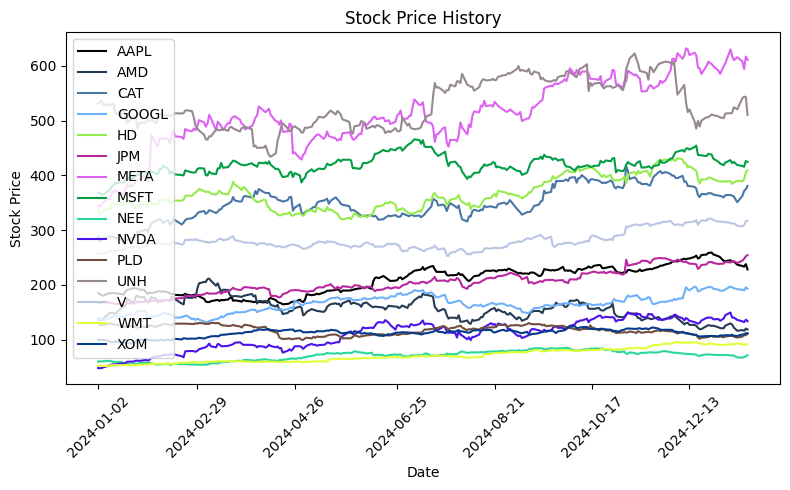

In [416]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 33.3%
Annual volatility: 13.3%
Sharpe Ratio: 2.35


AAPL     0.272367
AMD      0.769198
CAT      0.384900
GOOGL    0.374234
HD       0.258304
JPM      0.244040
META     0.504261
MSFT     0.334706
NEE      0.151598
NVDA     0.793060
PLD      0.277816
UNH      0.115393
V        0.195354
WMT      0.108478
XOM      0.117030
Name: mkt, dtype: float64

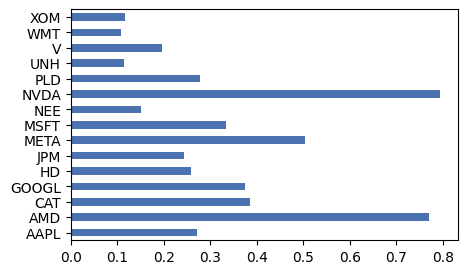

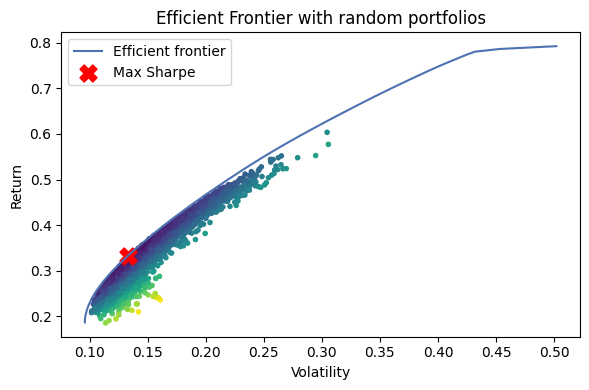

In [417]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [418]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [419]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [420]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[*********************100%***********************]  15 of 15 completed


In [421]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

,AAPL,AMD,CAT,GOOGL,HD,JPM,META,MSFT,NEE,NVDA,PLD,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,
2023-12-01,190.307678,121.389999,252.706909,131.383713,311.978546,152.395035,323.583954,371.730286,57.495758,46.747631,113.803802,538.725281,254.504669,50.649208,99.592743
2023-12-04,188.506485,118.570000,250.728607,128.803085,316.273346,153.512451,318.802216,366.400116,57.009903,45.493095,115.795815,539.828003,252.509903,50.636082,99.051224
2023-12-05,192.477051,118.379997,251.161667,130.516876,315.765778,153.493011,317.078796,369.754974,56.582355,46.552799,114.179115,541.777466,252.678604,51.105362,97.126862
2023-12-06,191.382431,116.820000,251.929367,129.550369,318.313324,151.880051,316.241974,366.062622,58.496616,45.490097,114.564049,541.058716,252.361038,50.550758,95.840744
2023-12-07,193.322922,128.369995,253.346619,136.435410,318.371948,152.346466,325.347198,368.196686,58.156517,46.582790,114.467804,539.818176,253.879440,50.218079,95.173492
2023-12-08,194.755890,128.919998,255.403641,134.502426,318.664734,154.027435,331.483734,371.452301,58.010765,47.492535,115.333893,541.295044,253.800049,49.691063,96.266228
2023-12-11,192.238205,134.410004,256.801270,132.808548,323.408539,154.591019,324.042175,368.544067,58.020477,46.613785,117.402870,535.298950,254.574097,49.816223,96.333916
2023-12-12,193.760773,137.610001,257.303162,132.041336,325.233856,155.970764,332.948181,371.601166,57.835857,47.643494,117.470238,537.307495,257.591064,49.855755,94.815704
2023-12-13,196.994919,138.190002,263.739960,132.091171,335.190002,156.495453,333.466156,371.591278,60.741249,48.074371,124.370064,540.546814,260.389679,50.741798,95.656998


#### Main class to integrate the LLM with the Portfolio Optimization model

In [422]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, verbose=False):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        stock_prices = f"The stock prices today are:\n"
        for i, ticker in enumerate(tickers):
            ticker_close = month_data[ticker]['price']
            stock_prices += f"{ticker} = {ticker_close}"
            if i != len(tickers) - 1:
                stock_prices += ", "
        stock_prices += "\n"

        stock_news = ""
        for ticker in tickers:
            ticker_news = month_data[ticker]['news']
            stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

        if iter == 0:
            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            "2. Any patterns in recent price movements.\n"
            "3. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.optimization_plan != [0.0] * self.n:
            current_prompt += (
                "Also, here is the **current optimizer plan**:\n"
                f"{self.optimization_plan}\n\n"
                "Decide whether you agree with the optimizer's plan. If you do, make any necessary adjustments to "
                "move your portfolio allocation closer to it.\n\n"
            )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. **Explain your decision process**. Discuss your reasoning and any trade-offs you considered.\n"
            "2. **Provide a recommended investment decision** for each stock in terms of confidence, choosing from "
            "one of the following 7 levels:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format()
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter} prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                else: # "MISSING TICKER"
                    new_message = "You must include a confidence level for each ticker. Please try again: " + self.response_format()

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} RETRY PROMPT: \n{new_message}\n")

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"[DEBUG]\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            for stock in tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                else:
                    retry = True
                    if verbose:
                        print("[DEBUG]\tInvalid format, retrying.")
                        print(f"[DEBUG]\tfetched weights: {result_dict}")
                    continue

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print("[DEBUG]\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if list(result_dict.keys()) != tickers:
                print(f"{list(result_dict.keys()) = }")
                if verbose: 
                    print("[DEBUG]\tInvalid output: not every ticker was outputted")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"[DEBUG]\tfetched weights: {result_dict = }")
                retry = False
            

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df)
                    print("\n```\n")

        return self.plan_histories

In [423]:
CoordFW = CoordinationFramework(
    mu, S, 0.93703, penalty=1, iteration=20, verbose=False)
# [goog, nvda, mstr, smci] -> 1.42
# 9 chat stocks -> 0.67
# 14 stocks -> 1.305
# 15 stocks -> 2.251+
#   not gonna go higher because 2000 requests per hour is stupid

#### Run the optimizer only, as baseline

In [424]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.06734091151147938,
  0.0584591701959829,
  0.06512000302436743,
  0.06775313468222308,
  0.06883307765239093,
  0.0689196084799159,
  0.06600733107561682,
  0.069822212005576,
  0.06553611476809883,
  0.06259217826181701,
  0.06333163566754925,
  0.07048345210699648,
  0.06864014487457643,
  0.0694956691709182,
  0.06766535652249323],
 [0.06647397575058196,
  0.04723557064261793,
  0.061493132367705296,
  0.05736049762673475,
  0.06874754626832216,
  0.07313405083122101,
  0.06235803121598003,
  0.06870213371085526,
  0.06689440477039317,
  0.052928910012283316,
  0.06371977983880739,
  0.08867631855300839,
  0.07209214313277959,
  0.07544253946522148,
  0.07474096581348298],
 [0.07200099491089405,
  0.03416751706901049,
  0.06274471561022119,
  0.060549139145057045,
  0.07198910104304404,
  0.0768948168035561,
  0.04464778744143189,
  0.06839686627651957,
  0.06946233676436371,
  0.03852683152574887,
  0.07068623172563433,
  0.09109470870138299,
  0.07538993032390397,
  0.08302581

#### Run the LLM only, as baseline

In [425]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, True)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)

llm_histories


# month 0 iter 0 prompt: 
Recent reports indicate:
For AAPL:
Apple Inc., traded under the ticker AAPL, is one of the world's largest companies, with a market cap of approximately $3.68 trillion as of January 2025. The company's primary revenue source is the iPhone, which accounts for about 48.7% of its total sales. Apple also generates significant revenue from its services segment and other products like Mac, iPad, and Apple Watch. The company has recently seen strong performance, with a 32.6% year-to-date increase in stock price, outpacing the S&P 500 and Nasdaq Composite indexes. Analysts, such as those at Wedbush, predict a strong holiday season and potential market cap of $4 trillion in early 2025, driven by AI-driven upgrades and a robust installed base of iOS devices[1][5].

For MSFT:
Microsoft Corporation (MSFT), listed on the Nasdaq Stock Market, is a tech giant with a diverse portfolio including Azure cloud services, Office 365, and gaming through its recent acquisition of Ac

[[0.0655737704918033,
  0.0655737704918033,
  0.08196721311475412,
  0.04918032786885248,
  0.03278688524590165,
  0.08196721311475412,
  0.0655737704918033,
  0.04918032786885248,
  0.0655737704918033,
  0.0655737704918033,
  0.0655737704918033,
  0.08196721311475412,
  0.0655737704918033,
  0.08196721311475412,
  0.08196721311475412],
 [0.05000000000000001,
  0.06666666666666668,
  0.10000000000000002,
  0.03333333333333334,
  0.06666666666666668,
  0.08333333333333336,
  0.03333333333333334,
  0.05000000000000001,
  0.06666666666666668,
  0.08333333333333336,
  0.06666666666666668,
  0.08333333333333336,
  0.06666666666666668,
  0.08333333333333336,
  0.06666666666666668],
 [0.03333333333333333,
  0.08333333333333333,
  0.09999999999999999,
  0.03333333333333333,
  0.049999999999999996,
  0.06666666666666667,
  0.06666666666666667,
  0.03333333333333333,
  0.08333333333333333,
  0.08333333333333333,
  0.06666666666666667,
  0.08333333333333333,
  0.08333333333333333,
  0.04999999999

#### Run the coordinator algorithm

In [426]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord


# month 0 iter 0 prompt: 
Recent reports indicate:
For AAPL:
Apple Inc., traded under the ticker AAPL, is one of the world's largest companies, with a market cap of approximately $3.68 trillion as of January 2025. The company's primary revenue source is the iPhone, which accounts for about 48.7% of its total sales. Apple also generates significant revenue from its services segment and other products like Mac, iPad, and Apple Watch. The company has recently seen strong performance, with a 32.6% year-to-date increase in stock price, outpacing the S&P 500 and Nasdaq Composite indexes. Analysts, such as those at Wedbush, predict a strong holiday season and potential market cap of $4 trillion in early 2025, driven by AI-driven upgrades and a robust installed base of iOS devices[1][5].

For MSFT:
Microsoft Corporation (MSFT), listed on the Nasdaq Stock Market, is a tech giant with a diverse portfolio including Azure cloud services, Office 365, and gaming through its recent acquisition of Ac

[[0.06645734100164133,
  0.0620164703438931,
  0.07354360806956078,
  0.05846673127553778,
  0.05080998144914629,
  0.07544341079733502,
  0.06579055078371006,
  0.059501269937214246,
  0.06555494262995107,
  0.06408297437681015,
  0.06445270307967627,
  0.0762253326108753,
  0.06710695768318986,
  0.07573144114283617,
  0.07481628481862368],
 [0.050180934593384234,
  0.061483614609870216,
  0.08944140578915152,
  0.04851115485443783,
  0.06511857530712711,
  0.08505205977215916,
  0.04875395747733171,
  0.05320425487148038,
  0.0684592676908678,
  0.06282305633171462,
  0.06769553719276297,
  0.09202285239769269,
  0.061151362895246995,
  0.08614597439204122,
  0.059955991824733455],
 [0.041896923699758726,
  0.06010811740288545,
  0.09319574492007526,
  0.04236125723879913,
  0.06120923032037766,
  0.08076616287570593,
  0.05674201200878849,
  0.04168540065195118,
  0.07909563802671474,
  0.05915828060074336,
  0.07282024823355937,
  0.0821951033116886,
  0.07329184157660777,
  0.083

#### Display results

In [427]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

,status,all AAPL,all MSFT,all NVDA,all GOOGL,all META,all JPM,all XOM,all UNH,all WMT,all HD,all CAT,all PLD,all NEE,all V,all AMD,llm AAPL,llm MSFT,llm NVDA,llm GOOGL,llm META,llm JPM,llm XOM,llm UNH,llm WMT,llm HD,llm CAT,llm PLD,llm NEE,llm V,llm AMD,opt AAPL,opt MSFT,opt NVDA,opt GOOGL,opt META,opt JPM,opt XOM,opt UNH,opt WMT,opt HD,opt CAT,opt PLD,opt NEE,opt V,opt AMD
0,CONVERGED month 0 iter 0,0.066457,0.062016,0.073544,0.058467,0.050810,0.075443,0.065791,0.059501,0.065555,0.064083,0.064453,0.076225,0.067107,7.573144e-02,0.074816,0.065574,0.065574,0.081967,0.049180,0.032787,0.081967,0.065574,0.049180,0.065574,0.065574,0.065574,0.081967,0.065574,0.081967,0.081967,6.734091e-02,5.845917e-02,6.512000e-02,6.775313e-02,6.883308e-02,6.891961e-02,6.600733e-02,6.982221e-02,6.553611e-02,6.259218e-02,6.333164e-02,7.048345e-02,6.864014e-02,6.949567e-02,6.766536e-02
1,CONVERGED month 1 iter 0,0.050181,0.061484,0.089441,0.048511,0.065119,0.085052,0.048754,0.053204,0.068459,0.062823,0.067696,0.092023,0.061151,8.614597e-02,0.059956,0.035088,0.070175,0.105263,0.052632,0.087719,0.087719,0.035088,0.052632,0.070175,0.070175,0.070175,0.087719,0.052632,0.087719,0.035088,6.527415e-02,5.279179e-02,7.361965e-02,4.439073e-02,4.251785e-02,8.238482e-02,6.242020e-02,5.377693e-02,6.674310e-02,5.547067e-02,6.521564e-02,9.632641e-02,6.967115e-02,8.457265e-02,8.482426e-02
2,month 2 iter 0,0.041897,0.060108,0.093196,0.042361,0.061209,0.080766,0.056742,0.041685,0.079096,0.059158,0.072820,0.082195,0.073292,8.311572e-02,0.072358,0.034483,0.068966,0.086207,0.034483,0.051724,0.068966,0.086207,0.034483,0.086207,0.068966,0.068966,0.068966,0.086207,0.068966,0.086207,4.931109e-02,5.125072e-02,1.001846e-01,5.023976e-02,7.069432e-02,9.256681e-02,2.727713e-02,4.888804e-02,7.198438e-02,4.935104e-02,7.667498e-02,9.542469e-02,6.037679e-02,9.726593e-02,5.850973e-02
3,CONVERGED month 2 iter 1,0.036600,0.061120,0.093197,0.037980,0.057394,0.076100,0.065712,0.034668,0.085960,0.059678,0.074579,0.074661,0.082175,7.865677e-02,0.081520,0.034483,0.068966,0.086207,0.034483,0.051724,0.068966,0.086207,0.034483,0.086207,0.068966,0.068966,0.068966,0.086207,0.068966,0.086207,3.871648e-02,5.327476e-02,1.001872e-01,4.147640e-02,6.306465e-02,8.323366e-02,4.521769e-02,3.485333e-02,8.571363e-02,5.039025e-02,8.019184e-02,8.035613e-02,7.814342e-02,8.834802e-02,7.683259e-02
4,month 3 iter 0,0.049594,0.072887,0.093471,0.062295,0.052337,0.072277,0.074044,0.030835,0.073629,0.069184,0.062303,0.053733,0.089383,8.229214e-02,0.061735,0.072727,0.072727,0.090909,0.090909,0.054545,0.072727,0.072727,0.036364,0.054545,0.072727,0.054545,0.036364,0.090909,0.090909,0.036364,2.646036e-02,7.304736e-02,9.603354e-02,3.368154e-02,5.012920e-02,7.182585e-02,7.536019e-02,2.530630e-02,9.271302e-02,6.564124e-02,7.006064e-02,7.110220e-02,8.785661e-02,7.367519e-02,8.710677e-02
5,CONVERGED month 3 iter 1,0.061513,0.086978,0.102309,0.080442,0.041895,0.070953,0.076751,0.021116,0.063760,0.073421,0.055068,0.039770,0.093330,8.630145e-02,0.046393,0.072727,0.090909,0.109091,0.090909,0.036364,0.072727,0.072727,0.018182,0.054545,0.072727,0.054545,0.036364,0.090909,0.090909,0.036364,5.029925e-02,8.304754e-02,9.552623e-02,6.997552e-02,4.742588e-02,6.917887e-02,8.077402e-02,2.404953e-02,7.297477e-02,7.411486e-02,5.559106e-02,4.317546e-02,9.575036e-02,8.169381e-02,5.642284e-02
6,month 4 iter 0,0.043860,0.035088,0.052632,0.035097,0.026316,0.035088,0.035088,0.017544,0.535078,0.035088,0.026316,0.035088,0.017544,2.631579e-02,0.043860,0.087719,0.070175,0.105263,0.070175,0.052632,0.070175,0.070175,0.035088,0.070175,0.070175,0.052632,0.070175,0.035088,0.052632,0.087719,8.043971e-12,5.084555e-12,4.409115e-12,1.952324e-05,4.787391e-12,5.218171e-12,5.145116e-12,4.624808e-12,9.999805e-01,4.907276e-12,3.901811e-12,5.948477e-12,5.146731e-12,6.292323e-12,1.014860e-11
7,CONVERGED month 4 iter 1,0.043860,0.035088,0.052632,0.035097,0.026316,0.035088,0.035088,0.017544,0.535078,0.035088,0.026316,0.035088,0.017544,2.631579e-02,0.043860,0.087719,0.0701

In [428]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [429]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

#### Graph the results

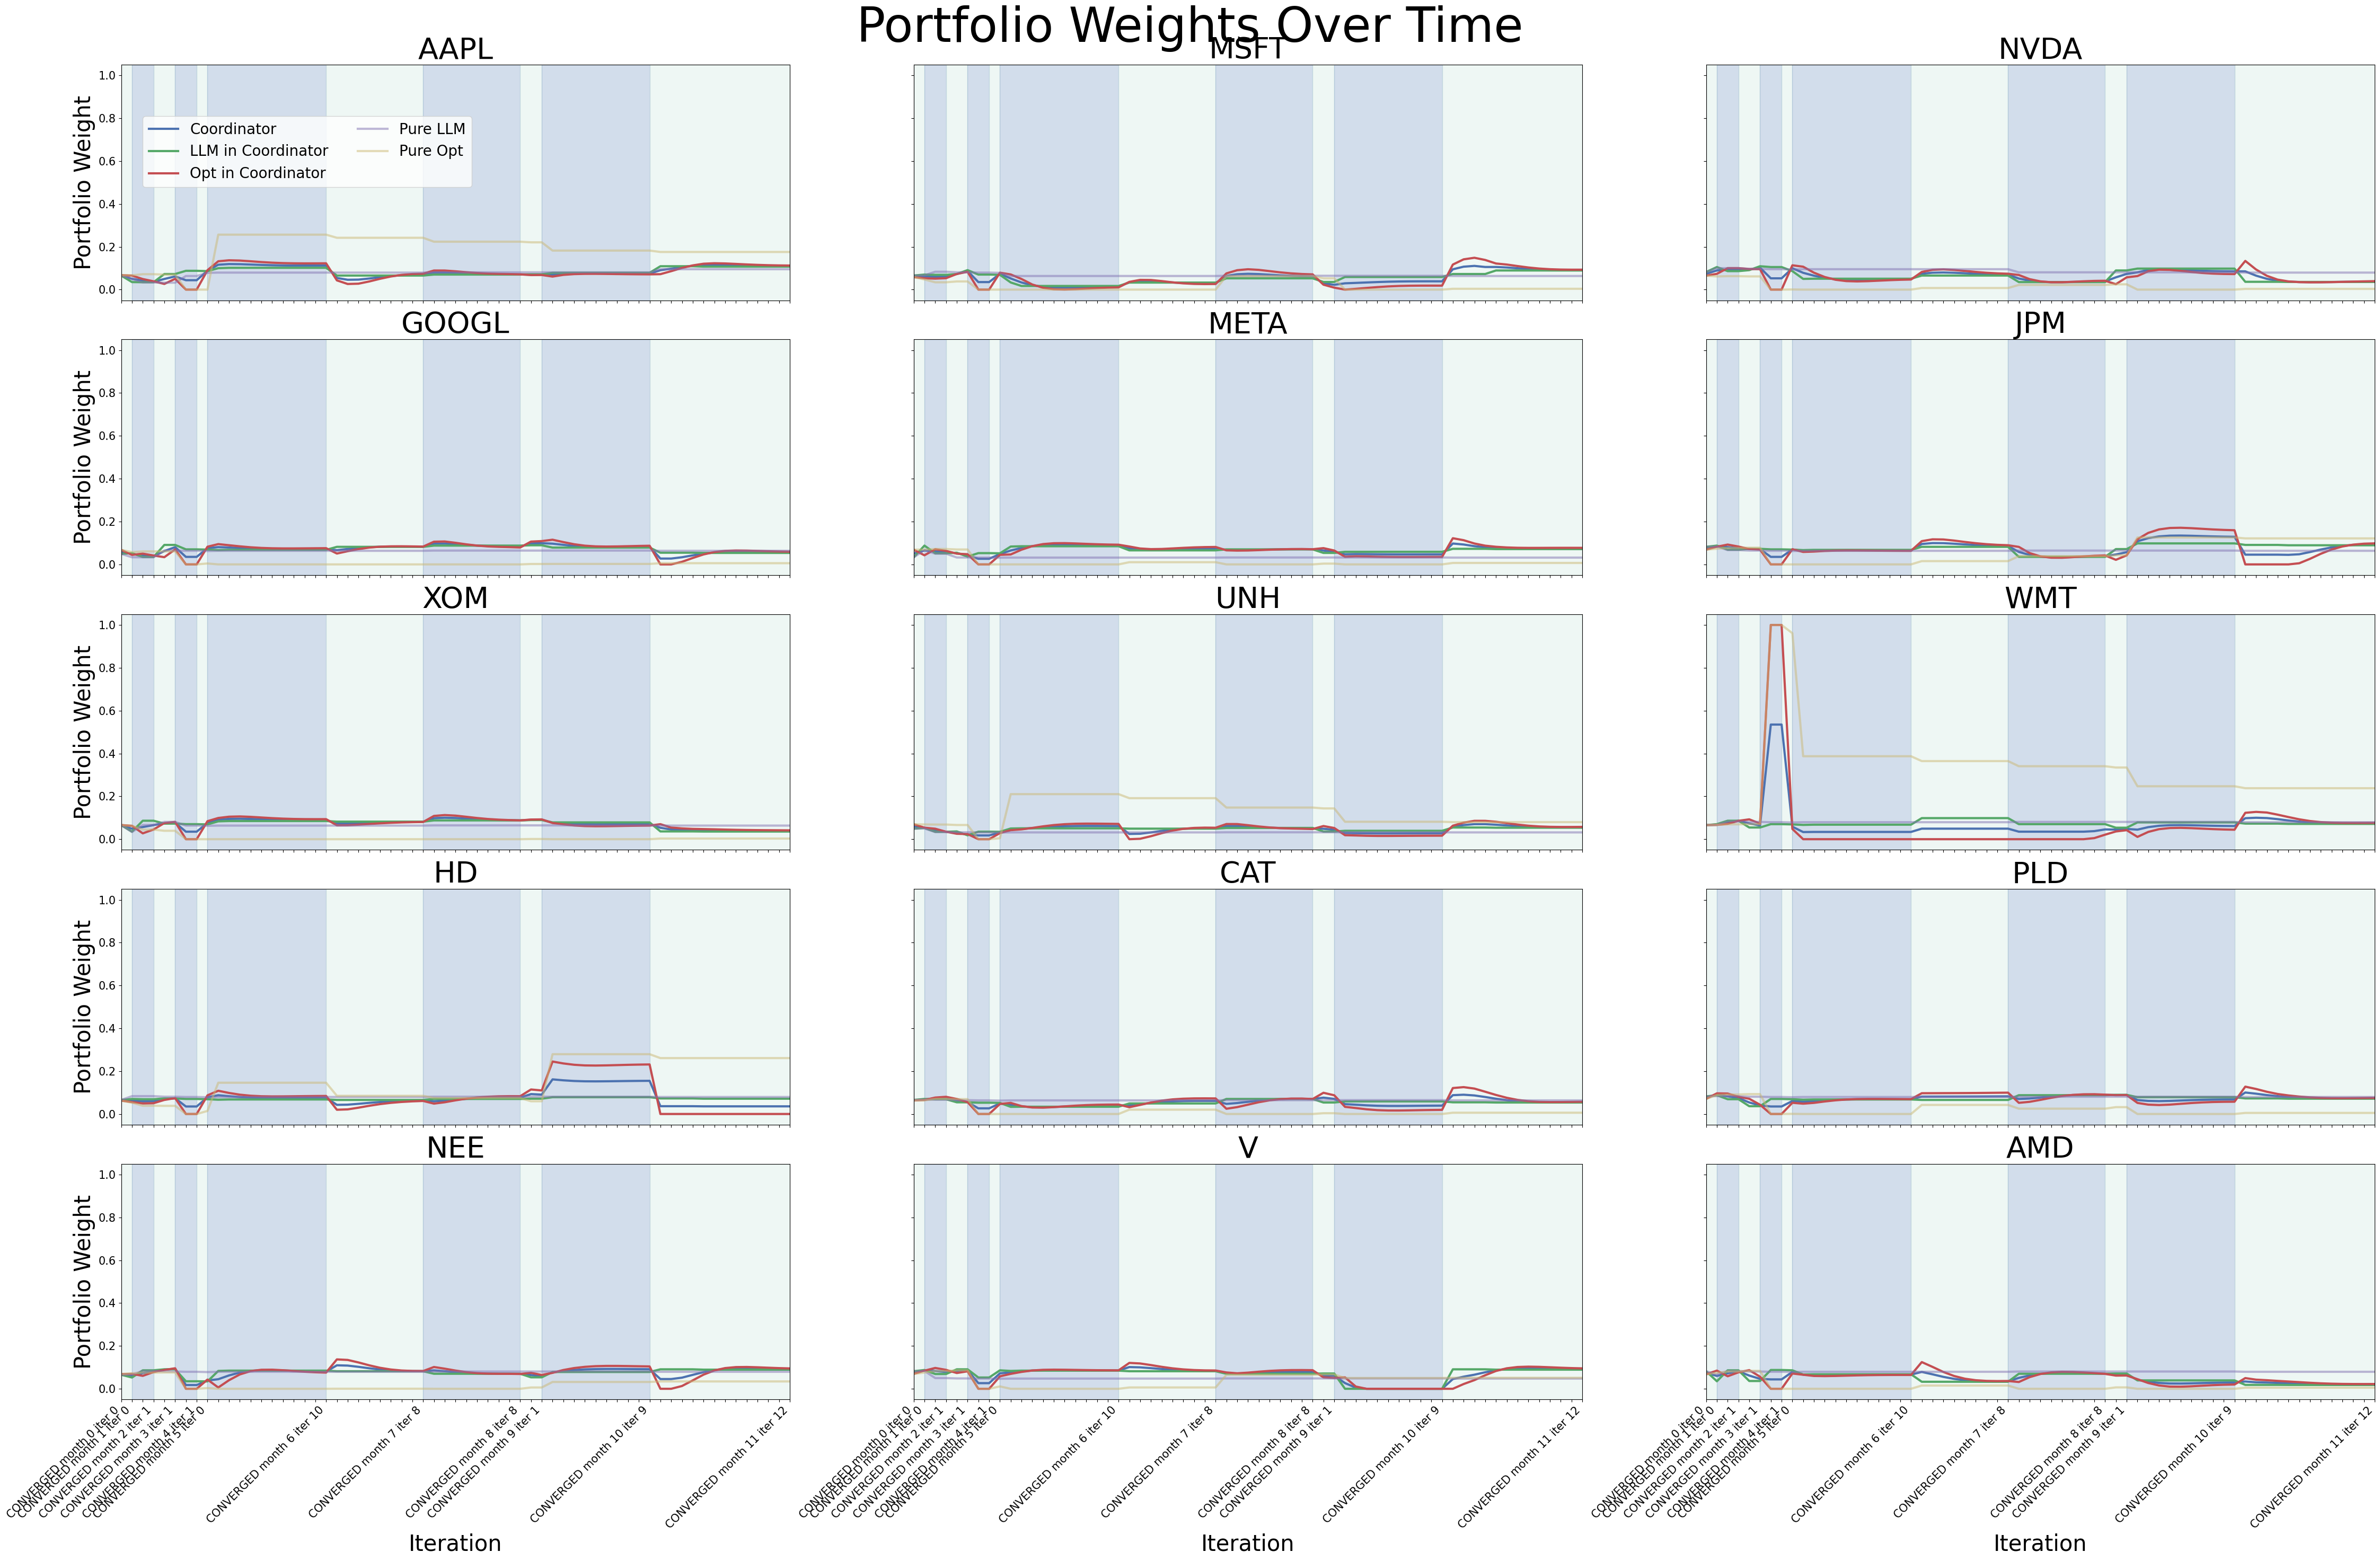

In [430]:
rows = 5
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i, ticker in enumerate(tickers):
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    # Plot lines
    if i == 0:
        axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=3)
        axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=3, alpha=0.5)
        axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=3, alpha=0.5)
    else:
        axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=3)
        axes[i].plot(df['status'], pure_llm_history[i], linewidth=3, alpha=0.5)
        axes[i].plot(df['status'], pure_opt_history[i], linewidth=3, alpha=0.5)
    
    # Title and tick parameters
    axes[i].set_title(f'{ticker}', fontsize=40)
    axes[i].tick_params(axis='x', rotation=45, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, rotation=45, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)
    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        axes[i].set_ylabel("Portfolio Weight", fontsize=30)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=30)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
fig.legend(loc=(0.06, 0.88), ncol=2, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300, bbox_inches='tight')  
plt.show()

#### Backtesting
Seeing how the strategies perform based on historical data

In [431]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)
all_weights = ["all " + ticker for ticker in tickers]

# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

12025.880944536844
11283.161696925297
12435.720170919836


#### Plot the backtesting

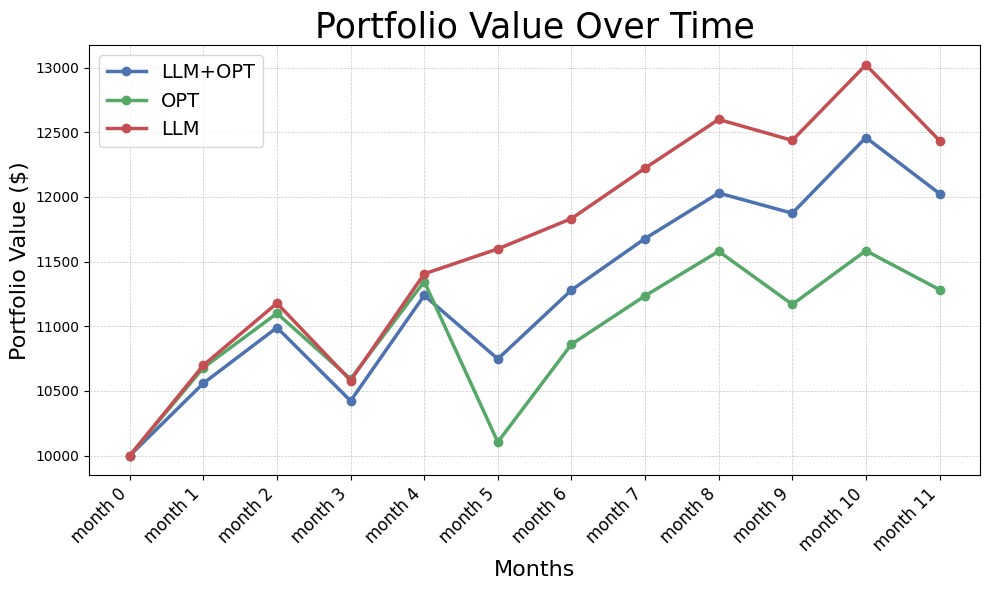

In [432]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=300, bbox_inches='tight')  
plt.show()